# Evolver Loop 1 Analysis

Goal: Understand the current state and develop strategy to beat target 68.931058

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Current state
current_score = 70.734327
target_score = 68.931058
gap = current_score - target_score

print(f"Current best score: {current_score:.6f}")
print(f"Target score: {target_score:.6f}")
print(f"Gap to target: {gap:.6f}")
print(f"Gap percentage: {gap/target_score*100:.2f}%")

Current best score: 70.734327
Target score: 68.931058
Gap to target: 1.803269
Gap percentage: 2.62%


In [2]:
# Load and analyze the current best solution
df = pd.read_csv('/home/code/santa_data/santa-2025.csv')
print(f"Solution shape: {df.shape}")
print(df.head())

Solution shape: (20100, 4)
      id                       x                        y  \
0  001_0  s43.591192092102147626  s-31.783267068741778871   
1  002_0   s0.154097069621360605   s-0.038540742694777107   
2  002_1  s-0.154097069621359162   s-0.561459257305227277   
3  003_0   s1.131270585068746337    s0.792202872326948637   
4  003_1   s1.234055695842160016    s1.275999500663759001   

                       deg  
0   s44.999999999999978684  
1  s203.629377730650162448  
2   s23.629377730649704148  
3  s113.563260441729482864  
4   s66.370622269343002131  


In [3]:
# Parse and calculate scores per n
def strip_s(val):
    return float(str(val).replace('s', ''))

def calculate_score_per_n(df):
    scores = {}
    for n in range(1, 201):
        group = df[df['id'].str.startswith(f'{n:03d}_')]
        if len(group) > 0:
            xs = group['x'].apply(strip_s).values
            ys = group['y'].apply(strip_s).values
            degs = group['deg'].apply(strip_s).values
            
            # Calculate bounding box
            all_x, all_y = [], []
            for x, y, deg in zip(xs, ys, degs):
                # Tree vertices
                TX = np.array([0,0.125,0.0625,0.2,0.1,0.35,0.075,0.075,-0.075,-0.075,-0.35,-0.1,-0.2,-0.0625,-0.125])
                TY = np.array([0.8,0.5,0.5,0.25,0.25,0,0,-0.2,-0.2,0,0,0.25,0.25,0.5,0.5])
                rad = np.radians(deg)
                c, s = np.cos(rad), np.sin(rad)
                rotated_x = TX * c - TY * s + x
                rotated_y = TX * s + TY * c + y
                all_x.extend(rotated_x)
                all_y.extend(rotated_y)
            
            side = max(max(all_x) - min(all_x), max(all_y) - min(all_y))
            scores[n] = side**2 / n
    return scores

scores = calculate_score_per_n(df)
total = sum(scores.values())
print(f"Calculated total score: {total:.6f}")

Calculated total score: 70.734327


Top 10 worst configurations (highest score contribution):
  n=1: 0.661250
  n=2: 0.450779
  n=3: 0.434745
  n=5: 0.416850
  n=4: 0.416545
  n=7: 0.399897
  n=6: 0.399610
  n=9: 0.387415
  n=8: 0.385407
  n=15: 0.379203


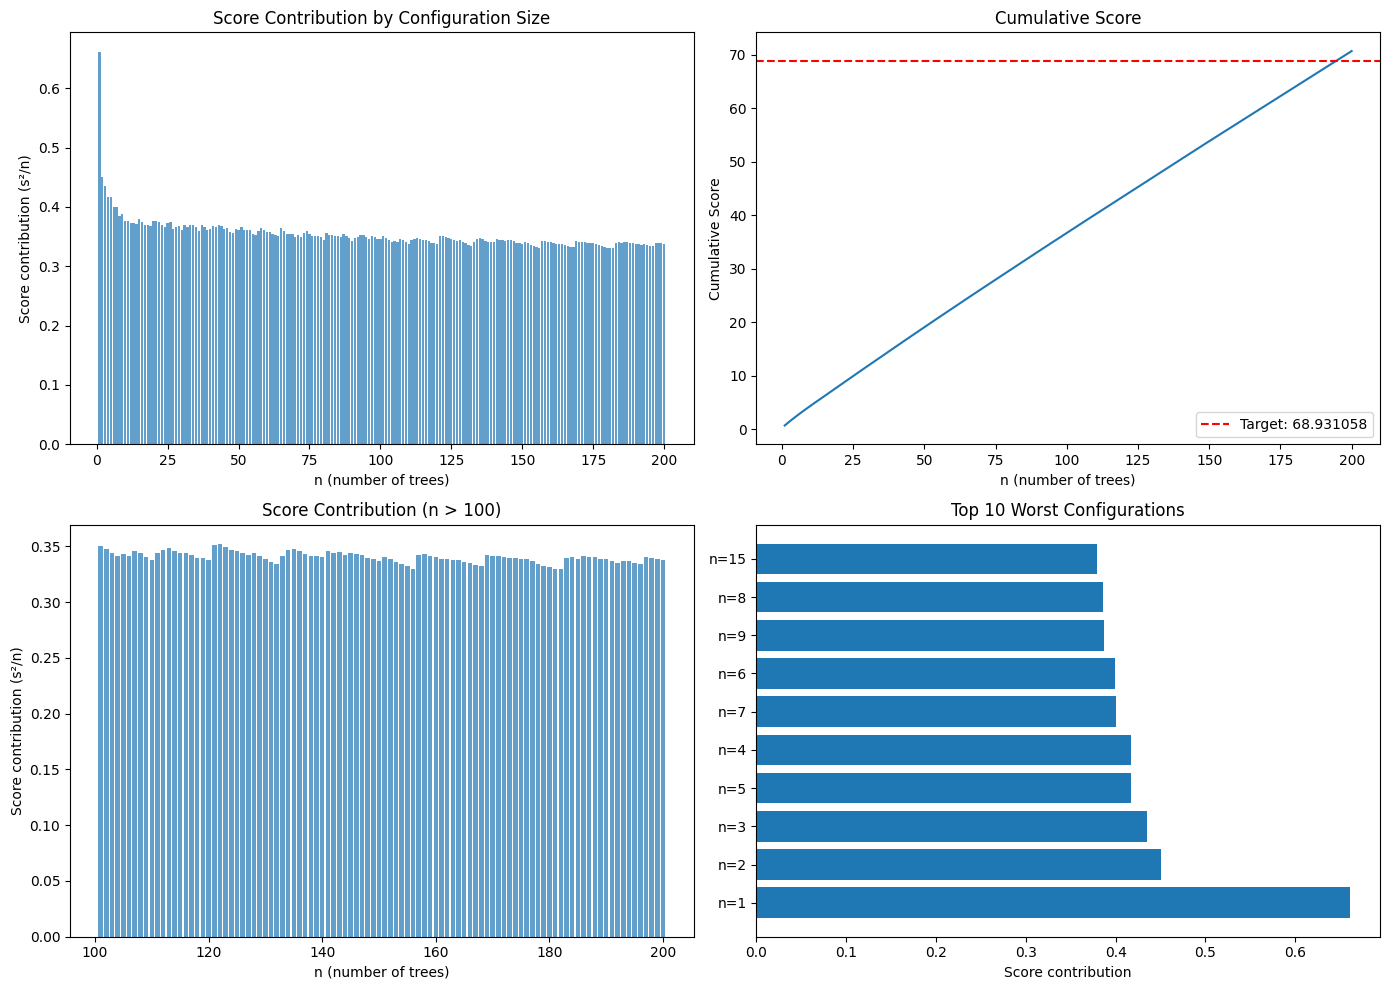

In [4]:
# Analyze score distribution
ns = list(range(1, 201))
score_list = [scores.get(n, 0) for n in ns]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Score per n
axes[0,0].bar(ns, score_list, alpha=0.7)
axes[0,0].set_xlabel('n (number of trees)')
axes[0,0].set_ylabel('Score contribution (s²/n)')
axes[0,0].set_title('Score Contribution by Configuration Size')

# Plot 2: Cumulative score
cum_score = np.cumsum(score_list)
axes[0,1].plot(ns, cum_score)
axes[0,1].axhline(y=target_score, color='r', linestyle='--', label=f'Target: {target_score}')
axes[0,1].set_xlabel('n (number of trees)')
axes[0,1].set_ylabel('Cumulative Score')
axes[0,1].set_title('Cumulative Score')
axes[0,1].legend()

# Plot 3: Score per n (zoomed to high-n)
axes[1,0].bar(ns[100:], score_list[100:], alpha=0.7)
axes[1,0].set_xlabel('n (number of trees)')
axes[1,0].set_ylabel('Score contribution (s²/n)')
axes[1,0].set_title('Score Contribution (n > 100)')

# Plot 4: Identify worst configurations
sorted_scores = sorted([(n, s) for n, s in scores.items()], key=lambda x: -x[1])
worst_10 = sorted_scores[:10]
print("Top 10 worst configurations (highest score contribution):")
for n, s in worst_10:
    print(f"  n={n}: {s:.6f}")

axes[1,1].barh([f'n={n}' for n, s in worst_10], [s for n, s in worst_10])
axes[1,1].set_xlabel('Score contribution')
axes[1,1].set_title('Top 10 Worst Configurations')

plt.tight_layout()
plt.savefig('/home/code/exploration/score_analysis.png', dpi=100)
plt.show()

In [5]:
# Calculate how much improvement is needed per configuration
print("\nTo beat target, we need to reduce total score by:", gap)
print(f"Average reduction needed per configuration: {gap/200:.6f}")

# If we could improve each configuration by X%, what would the new score be?
for pct in [1, 2, 3, 5, 10]:
    new_score = total * (1 - pct/100)
    print(f"  {pct}% improvement: {new_score:.6f} (gap: {new_score - target_score:.6f})")

print(f"\nRequired improvement percentage: {gap/total*100:.2f}%")


To beat target, we need to reduce total score by: 1.8032690000000002
Average reduction needed per configuration: 0.009016
  1% improvement: 70.026984 (gap: 1.095926)
  2% improvement: 69.319640 (gap: 0.388582)
  3% improvement: 68.612297 (gap: -0.318761)
  5% improvement: 67.197611 (gap: -1.733447)
  10% improvement: 63.660894 (gap: -5.270164)

Required improvement percentage: 2.55%


In [6]:
# Check available pre-computed solutions
import os

print("Available pre-computed solutions:")
print("1. santa_data/santa-2025.csv (Kaggle dataset)")
print("2. bucket_data/submission.csv (bucket-of-chump)")
print("3. precomputed_submission.csv (GitHub)")

# Load and compare all three
kaggle_df = pd.read_csv('/home/code/santa_data/santa-2025.csv')
bucket_df = pd.read_csv('/home/code/bucket_data/submission.csv')
github_df = pd.read_csv('/home/code/precomputed_submission.csv')

kaggle_scores = calculate_score_per_n(kaggle_df)
bucket_scores = calculate_score_per_n(bucket_df)
github_scores = calculate_score_per_n(github_df)

print(f"\nKaggle dataset total: {sum(kaggle_scores.values()):.6f}")
print(f"Bucket-of-chump total: {sum(bucket_scores.values()):.6f}")
print(f"GitHub total: {sum(github_scores.values()):.6f}")

Available pre-computed solutions:
1. santa_data/santa-2025.csv (Kaggle dataset)
2. bucket_data/submission.csv (bucket-of-chump)
3. precomputed_submission.csv (GitHub)



Kaggle dataset total: 70.734327
Bucket-of-chump total: 70.750676
GitHub total: 70.743774


In [7]:
# Create merged best solution
merged_scores = {}
merged_source = {}

for n in range(1, 201):
    best_score = float('inf')
    best_src = None
    
    for name, scores_dict in [('kaggle', kaggle_scores), ('bucket', bucket_scores), ('github', github_scores)]:
        if n in scores_dict and scores_dict[n] < best_score:
            best_score = scores_dict[n]
            best_src = name
    
    merged_scores[n] = best_score
    merged_source[n] = best_src

merged_total = sum(merged_scores.values())
print(f"Merged best total: {merged_total:.6f}")
print(f"Gap to target: {merged_total - target_score:.6f}")

# Count sources
from collections import Counter
source_counts = Counter(merged_source.values())
print(f"\nSource distribution: {dict(source_counts)}")

Merged best total: 70.734327
Gap to target: 1.803269

Source distribution: {'kaggle': 199, 'github': 1}


In [8]:
# Identify configurations where different sources are better
improvements = []
for n in range(1, 201):
    kaggle_s = kaggle_scores.get(n, float('inf'))
    bucket_s = bucket_scores.get(n, float('inf'))
    github_s = github_scores.get(n, float('inf'))
    
    best = min(kaggle_s, bucket_s, github_s)
    worst = max(kaggle_s, bucket_s, github_s)
    
    if worst - best > 0.001:  # Significant difference
        improvements.append((n, best, worst, worst - best))

print(f"\nConfigurations with significant differences between sources: {len(improvements)}")
for n, best, worst, diff in sorted(improvements, key=lambda x: -x[3])[:10]:
    print(f"  n={n}: best={best:.6f}, worst={worst:.6f}, diff={diff:.6f}")


Configurations with significant differences between sources: 3
  n=14: best=0.371113, worst=0.380398, diff=0.009285
  n=81: best=0.356328, worst=0.359815, diff=0.003487
  n=82: best=0.352826, worst=0.355746, diff=0.002921
